In [1]:
import numpy as np
import pandas as pd
import os
import networkx as nx
import random
import mutation
import crossover
import generator
import fitness
from datetime import datetime

In [2]:
# user given constants
src=0
dst=3
bandwidth_threshold = 2
# parameters
generation = 100
max_depth = 5
population_size = 80

In [3]:
random.seed(datetime.now())

In [4]:
#Read file related to testing
def get_test_file():
    '''Generator that return string of file name'''
    import re
    for files in os.listdir():
        if re.match('test.+\.csv', files) is not None:
            yield files
            
def csv_to_np(filename):
    return pd.read_csv(filename, header=None, delim_whitespace=True).values

# Use generator
#bandwidth_matrix = generator.generate("complete", (1, 15), n=15).out(type="2d_list")
bandwidth_matrix = generator.generate("complete", (1, 100), n=15).out(type="2d_list")


#bandwidth_matrix = csv_to_np('test1.csv')
print(type(bandwidth_matrix), '\n', bandwidth_matrix)

<class 'numpy.ndarray'> 
 [[ 0 48 34 90 50 12 49 40 66 59 46 97 45 28 57]
 [48  0 95 22 97 79  7 23 49 82 92 71  8 54 40]
 [34 95  0 57 41 18 76 63 92 42 53  3 45 41 23]
 [90 22 57  0  3  2 26 26 93 80 81 88 29 14 31]
 [50 97 41  3  0 82 42 56 15 16 74 36  1 16 30]
 [12 79 18  2 82  0 92 30 84 69 69 51 66 17 89]
 [49  7 76 26 42 92  0 28 30 71 43 32 89 56 86]
 [40 23 63 26 56 30 28  0 76 16 84 72 71  2 61]
 [66 49 92 93 15 84 30 76  0  2 43 52 98 67 81]
 [59 82 42 80 16 69 71 16  2  0 48 56 86 38 87]
 [46 92 53 81 74 69 43 84 43 48  0 53  7 23 31]
 [97 71  3 88 36 51 32 72 52 56 53  0 55 92 98]
 [45  8 45 29  1 66 89 71 98 86  7 55  0 45 33]
 [28 54 41 14 16 17 56  2 67 38 23 92 45  0 49]
 [57 40 23 31 30 89 86 61 81 87 31 98 33 49  0]]


In [5]:
def np_to_nx(bandwidth_matrix):
    # build neighbor matrix
    neighbor_matrix = []
    for row, _ in enumerate(bandwidth_matrix):
        neighbor_matrix.append(np.where(bandwidth_matrix[row] > 0)[0])
    neighbor_matrix = np.array(neighbor_matrix)
    
    # build the list of edges
    edges = np.array(np.where(bandwidth_matrix > 0)).transpose()

    # build nx Graph instance
    G = nx.Graph()
    num_of_nodes = bandwidth_matrix.shape[0]
    G.add_nodes_from(range(num_of_nodes))
    G.add_edges_from(edges)
    return G, neighbor_matrix
    
G, neighbor_matrix = np_to_nx(bandwidth_matrix)

/home/phua/anaconda3/envs/evo/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


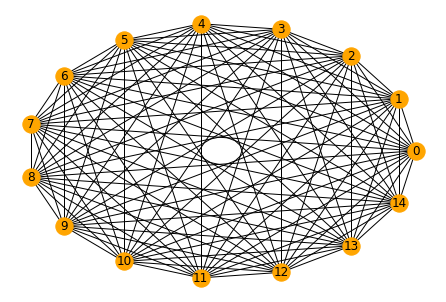

In [6]:
def nx_visualize(G):
    # Visualize the graph
    %matplotlib inline
    nx.draw_shell(G, with_labels=True, node_color='orange')

nx_visualize(G)

In [7]:
def initial(G, s, d, iddfs_depth, population_size):

    # Add shortest paths (seeding)
    shortest_path_generator = nx.all_shortest_paths(G, source=s, target=d)
    shortest_paths = list(shortest_path_generator)
    
    # Add worse path
    path_generator = nx.all_simple_paths(G, source=0, target=3, cutoff=iddfs_depth)
    paths = list(path_generator)
    #population_size = min(len(paths), population_size)

    long_paths = random.sample(paths, population_size - len(shortest_paths))
    #print("short:", shortest_paths)
    #print("long:", long_paths)
    #global bandwidth_matrix
    #for p in paths:
      #  fit = fitness.fitness(p, bandwidth_matrix)

        #print(fitness.fitness(p, bandwidth_matrix), end=',')
    return shortest_paths+long_paths

# for example, given src=0, dst=3, max_depth=7, population_size=20
pop = initial(G, src, dst, max_depth, population_size)
print(pop)

[[0, 3], [0, 11, 4, 2, 14, 3], [0, 7, 14, 9, 8, 3], [0, 1, 6, 13, 2, 3], [0, 11, 13, 8, 1, 3], [0, 1, 6, 7, 3], [0, 7, 12, 9, 6, 3], [0, 14, 4, 10, 7, 3], [0, 14, 12, 13, 6, 3], [0, 6, 1, 9, 3], [0, 7, 6, 1, 2, 3], [0, 6, 14, 1, 7, 3], [0, 9, 6, 1, 12, 3], [0, 4, 12, 13, 8, 3], [0, 7, 2, 9, 13, 3], [0, 12, 1, 4, 13, 3], [0, 11, 12, 4, 7, 3], [0, 12, 8, 1, 14, 3], [0, 4, 12, 11, 8, 3], [0, 9, 8, 7, 1, 3], [0, 12, 11, 1, 9, 3], [0, 11, 10, 7, 1, 3], [0, 1, 6, 4, 11, 3], [0, 6, 2, 1, 3], [0, 5, 12, 2, 7, 3], [0, 1, 13, 8, 4, 3], [0, 12, 13, 8, 3], [0, 11, 14, 1, 7, 3], [0, 9, 7, 10, 8, 3], [0, 2, 11, 7, 1, 3], [0, 7, 8, 13, 5, 3], [0, 6, 2, 8, 12, 3], [0, 7, 14, 8, 3], [0, 14, 13, 2, 12, 3], [0, 7, 6, 12, 3], [0, 14, 13, 1, 8, 3], [0, 12, 14, 8, 11, 3], [0, 11, 14, 5, 2, 3], [0, 9, 5, 8, 4, 3], [0, 13, 7, 5, 8, 3], [0, 4, 10, 11, 14, 3], [0, 13, 11, 9, 6, 3], [0, 2, 14, 6, 12, 3], [0, 2, 1, 11, 9, 3], [0, 7, 12, 10, 5, 3], [0, 10, 2, 5, 7, 3], [0, 2, 6, 12, 10, 3], [0, 13, 2, 6, 11, 3], [

In [8]:
# Edge density of graph
# This is for calculating parameter (但現在還沒做)
edge_density = G.size()*2/G.order()*(G.order()-1)
print(edge_density)

196.0


In [9]:
# main loop
new_pop = []
for g in range(generation):
    #display(pd.DataFrame(fitness.population_with_fitness(pop, bandwidth_matrix)))
    children_pop = []
    
    # crossover
    for idx in range(len(pop)-1):
        child1, child2 = crossover.random_crossover(pop[idx], pop[idx+1], bandwidth_matrix)
        pop += [crossover.check_cycle(child1), crossover.check_cycle(child2)]
    
    # mutation
    for ind in pop:
        children_pop.append(crossover.check_cycle(mutation.mutation(neighbor_matrix, ind)))

    # diversity maintenance
    pop = np.unique(pop+children_pop).tolist()
    
    # fitness evaluation
    pop_with_fit = fitness.population_with_fitness(pop, bandwidth_matrix)
    
    # selection
    pop = pd.DataFrame(sorted(pop_with_fit, key=lambda ind: ind['fitness'], reverse=True))
    #display(pop)
    pop = pop['individual'][0:population_size].tolist()

# count path length of each individual
path_length = []
for ind in pop:
    path_length.append(len(ind))

In [10]:
pop_with_fit = fitness.population_with_fitness(pop, bandwidth_matrix)
rst = pd.DataFrame(sorted(pop_with_fit, key=lambda ind: ind['fitness'], reverse=True))
rst['hop'] = path_length
rst.head()

,fitness,individual,hop
0,90,"[0, 3]",2
1,88,"[0, 11, 3]",3
2,88,"[0, 11, 14, 11, 3]",5
3,81,"[0, 3, 10, 3, 8, 3]",6
4,80,"[0, 3, 9, 1, 10, 3]",6


In [11]:
# Ref: https://pythonhealthcare.org/tag/pareto-front/
def identify_pareto(scores):
    
    # flip num_of_hops to negative so that we can maxmize it
    scores[:,1] = -scores[:,1]
    
    # Count number of items
    population_size = scores.shape[0]
    # Create a NumPy index for scores on the pareto front (zero indexed)
    population_ids = np.arange(population_size)
    # Create a starting list of items on the Pareto front
    # All items start off as being labelled as on the Parteo front
    pareto_front = np.ones(population_size, dtype=bool)
    # Loop through each item. This will then be compared with all other items
    for i in range(population_size):
        # Loop through all other items
        for j in range(population_size):
            
            # Check if our 'i' pint is dominated by out 'j' point
            if all(scores[j] >= scores[i]) and any(scores[j] > scores[i]):
                # j dominates i. Label 'i' point as not on Pareto front
                pareto_front[i] = 0
                # Stop further comparisons with 'i' (no more comparisons needed)
                break
   
    # Add the right-most & down-most points
    max_bandwidth = max(scores[:, 0])
    min_length = max(scores[:, 1])

    for i in range(population_size):
        if scores[i][0] == max_bandwidth or scores[i][1] == min_length:
            pareto_front[i] = 1
    
    
    # flip back the negative sign of num_of_hops
    scores[:,1] = -scores[:,1]
    
    # Return ids of scenarios on pareto front
    return population_ids[pareto_front]


In [12]:
data = rst.drop(columns='individual').values
front_idx = identify_pareto(data)
pareto_front= data[front_idx]
pareto_front.sort(axis=0)
pareto_front

array([[90,  2]])

In [13]:
all(data[0] > data[1]) 

False

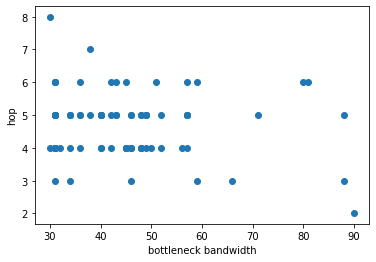

In [14]:
import matplotlib.pyplot as plt
plt.scatter(rst['fitness'], rst['hop'])
plt.plot(pareto_front[:, 0], pareto_front[:, 1], color='r')
plt.xlabel('bottleneck bandwidth')
plt.ylabel('hop')
plt.show()
#plt.

In [15]:
rst

,fitness,individual,hop
0,90,"[0, 3]",2
1,88,"[0, 11, 3]",3
2,88,"[0, 11, 14, 11, 3]",5
3,81,"[0, 3, 10, 3, 8, 3]",6
4,80,"[0, 3, 9, 1, 10, 3]",6
5,71,"[0, 11, 1, 10, 3]",5
6,66,"[0, 8, 3]",3
7,59,"[0, 9, 3]",3
8,59,"[0, 9, 14, 5, 8, 3]",6
9,57,"[0, 9, 6, 2, 3]",5


In [16]:
#pop


In [17]:
pd.DataFrame(bandwidth_matrix)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0,48,34,90,50,12,49,40,66,59,46,97,45,28,57
1,48,0,95,22,97,79,7,23,49,82,92,71,8,54,40
2,34,95,0,57,41,18,76,63,92,42,53,3,45,41,23
3,90,22,57,0,3,2,26,26,93,80,81,88,29,14,31
4,50,97,41,3,0,82,42,56,15,16,74,36,1,16,30
5,12,79,18,2,82,0,92,30,84,69,69,51,66,17,89
6,49,7,76,26,42,92,0,28,30,71,43,32,89,56,86
7,40,23,63,26,56,30,28,0,76,16,84,72,71,2,61
8,66,49,92,93,15,84,30,76,0,2,43,52,98,67,81
9,59,82,42,80,16,69,71,16,2,0,48,56,86,38,87


In [18]:
#bandwidth_matrix.transpose() == bandwidth_matrix

In [21]:
bandwidth_matrix[3][12]

29

In [20]:
fitness.population_with_fitness([[0, 12, 3]], bandwidth_matrix)

[{'individual': [0, 12, 3], 'fitness': 29}]